# Load and Prepare Data



In [ ]:
import pandas as pd

population_df = pd.read_csv('/content/State population - Population.csv')

# Convert 'Year' column to datetime objects (assuming 'Year' is the date column)
population_df['Year'] = pd.to_datetime(population_df['Year'], format='%Y')

# Rename 'Year' to 'Date' to match the desired long format structure
population_df = population_df.rename(columns={'Year': 'Date'})

# Melt the DataFrame to long format
population_long_df = pd.melt(population_df, id_vars=['Date'], var_name='State', value_name='Population')

# Convert 'Population' to numeric, removing commas
population_long_df['Population'] = population_long_df['Population'].str.replace(',', '').astype(float)

# Handle missing values by forward-filling and then backward-filling within each state group
population_long_df['Population'] = population_long_df.groupby('State')['Population'].transform(lambda x: x.ffill().bfill())

print("Population data loaded, converted to datetime, transformed to long format, and missing values handled.")
population_long_df.head()

Population data loaded, converted to datetime, transformed to long format, and missing values handled.


,Date,State,Population
0,2006-01-01,Washington,6420258.0
1,2007-01-01,Washington,6525086.0
2,2008-01-01,Washington,6608245.0
3,2009-01-01,Washington,6672159.0
4,2010-01-01,Washington,6743226.0


In [ ]:
assault_df = pd.read_excel('/content/GB 740 Project Data.xlsx', sheet_name='Assault')
homicide_df = pd.read_excel('/content/GB 740 Project Data.xlsx', sheet_name='Homicide')
rape_df = pd.read_excel('/content/GB 740 Project Data.xlsx', sheet_name='Rape')
robbery_df = pd.read_excel('/content/GB 740 Project Data.xlsx', sheet_name='Robbery')

print("Crime datasets (Assault, Homicide, Rape, Robbery) loaded successfully.")

print("Assault Data Head:")
print(assault_df.head())
print("\nHomicide Data Head:")
print(homicide_df.head())
print("\nRape Data Head:")
print(rape_df.head())
print("\nRobbery Data Head:")
print(robbery_df.head())

Crime datasets (Assault, Homicide, Rape, Robbery) loaded successfully.
Assault Data Head:
        Date  Colorado  Idaho  Maine  New Hampshire  North Carolina  Utah  \
0 2006-11-01       840    218     65             78            1808   240   
1 2006-12-01      1360    199     70             86            1821   284   
2 2007-01-01       798    186     50             54            1877   253   
3 2007-02-01       744    198     60             57            1594   233   
4 2007-03-01       910    241     55             70            2095   287   

   Virginia  Washington  
0       894         891  
1       805         919  
2       811         945  
3       792         827  
4       874        1098  

Homicide Data Head:
        Date  Colorado  Idaho  Maine  New Hampshire  North Carolina  Utah  \
0 2006-11-01        23      2      5              0              46     2   
1 2006-12-01        20      4      0              0              41     6   
2 2007-01-01         7      5      2   

In [ ]:
def process_crime_data(df, crime_type, population_df):
    df_melted = pd.melt(df, id_vars=['Date'], var_name='State', value_name=crime_type)
    df_melted['Date'] = pd.to_datetime(df_melted['Date'])

    # Extract year and month from crime_df dates to align with population_df year
    df_melted['Year'] = df_melted['Date'].dt.year
    population_df['Year'] = population_df['Date'].dt.year

    # Merge with population data on 'State' and 'Year'
    merged_df = pd.merge(df_melted, population_df[['State', 'Year', 'Population']], on=['State', 'Year'], how='left')

    # Drop the temporary 'Year' column
    merged_df.drop(columns=['Year'], inplace=True)
    population_df.drop(columns=['Year'], inplace=True)

    # Calculate crime rate per 100,000 population
    merged_df[f'{crime_type}_Rate'] = (merged_df[crime_type] / merged_df['Population']) * 100000
    return merged_df

assault_rates_df = process_crime_data(assault_df, 'Assault', population_long_df.copy())
homicide_rates_df = process_crime_data(homicide_df, 'Homicide', population_long_df.copy())
rape_rates_df = process_crime_data(rape_df, 'Rape', population_long_df.copy())
robbery_rates_df = process_crime_data(robbery_df, 'Robbery', population_long_df.copy())

print("Crime rates calculated for Assault, Homicide, Rape, and Robbery.")
print("\nAssault Rates Head:")
print(assault_rates_df.head())
print("\nHomicide Rates Head:")
print(homicide_rates_df.head())
print("\nRape Rates Head:")
print(rape_rates_df.head())
print("\nRobbery Rates Head:")
print(robbery_rates_df.head())

Crime rates calculated for Assault, Homicide, Rape, and Robbery.

Assault Rates Head:
        Date     State  Assault  Population  Assault_Rate
0 2006-11-01  Colorado      840   4720423.0     17.795015
1 2006-12-01  Colorado     1360   4720423.0     28.810977
2 2007-01-01  Colorado      798   4803868.0     16.611614
3 2007-02-01  Colorado      744   4803868.0     15.487520
4 2007-03-01  Colorado      910   4803868.0     18.943068

Homicide Rates Head:
        Date     State  Homicide  Population  Homicide_Rate
0 2006-11-01  Colorado        23   4720423.0       0.487244
1 2006-12-01  Colorado        20   4720423.0       0.423691
2 2007-01-01  Colorado         7   4803868.0       0.145716
3 2007-02-01  Colorado        13   4803868.0       0.270615
4 2007-03-01  Colorado         6   4803868.0       0.124899

Rape Rates Head:
        Date     State  Rape  Population  Rape_Rate
0 2006-11-01  Colorado   143   4720423.0   3.029390
1 2006-12-01  Colorado   292   4720423.0   6.185886
2 2007-01-

# Analyze Assault Rates


##Colorado v. Utah



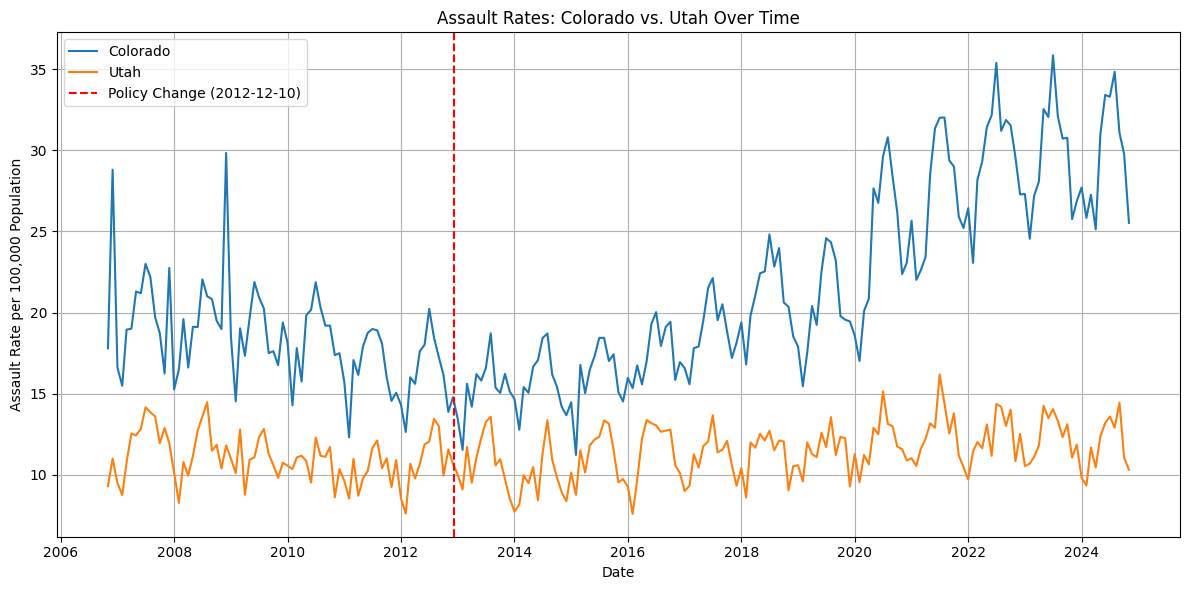

Time series plot for Colorado vs. Utah assault rates generated.


In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import statsmodels.formula.api as smf

policy_date_co_ut = pd.to_datetime('2012-12-10')

# Filter assault_rates_df for Colorado and Utah
assault_co_ut = assault_rates_df[assault_rates_df['State'].isin(['Colorado', 'Utah'])].copy()

# Plotting time series for Colorado vs. Utah
plt.figure(figsize=(12, 6))
for state in ['Colorado', 'Utah']:
    state_data = assault_co_ut[assault_co_ut['State'] == state]
    plt.plot(state_data['Date'], state_data['Assault_Rate'], label=state)

plt.axvline(x=policy_date_co_ut, color='red', linestyle='--', label=f'Policy Change ({policy_date_co_ut.strftime("%Y-%m-%d")})')
plt.title('Assault Rates: Colorado vs. Utah Over Time')
plt.xlabel('Date')
plt.ylabel('Assault Rate per 100,000 Population')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

print("Time series plot for Colorado vs. Utah assault rates generated.")

In [ ]:
policy_date_co_ut = pd.to_datetime('2012-12-10')

# Prepare indicator variables for DID analysis
assault_co_ut['Colorado_Treated'] = assault_co_ut['State'].apply(lambda x: 1 if x == 'Colorado' else 0)
assault_co_ut['Post_Legal'] = (assault_co_ut['Date'] > policy_date_co_ut).astype(int)

print("Indicator variables 'Colorado_Treated' and 'Post_Legal' created.")
print(assault_co_ut.head())

# Run OLS regression model
did_model_assault_co_ut = smf.ols('Assault_Rate ~ Colorado_Treated + Post_Legal + Colorado_Treated:Post_Legal', data=assault_co_ut).fit()
print("\nOLS Regression Model Summary for Assault Rates (Colorado vs. Utah):")
print(did_model_assault_co_ut.summary())

Indicator variables 'Colorado_Treated' and 'Post_Legal' created.
        Date     State  Assault  Population  Assault_Rate  Colorado_Treated  \
0 2006-11-01  Colorado      840   4720423.0     17.795015                 1   
1 2006-12-01  Colorado     1360   4720423.0     28.810977                 1   
2 2007-01-01  Colorado      798   4803868.0     16.611614                 1   
3 2007-02-01  Colorado      744   4803868.0     15.487520                 1   
4 2007-03-01  Colorado      910   4803868.0     18.943068                 1   

   Post_Legal  
0           0  
1           0  
2           0  
3           0  
4           0  

OLS Regression Model Summary for Assault Rates (Colorado vs. Utah):
                            OLS Regression Results                            
Dep. Variable:           Assault_Rate   R-squared:                       0.613
Model:                            OLS   Adj. R-squared:                  0.610
Method:                 Least Squares   F-statistic:      

##Maine v. New Hampshire


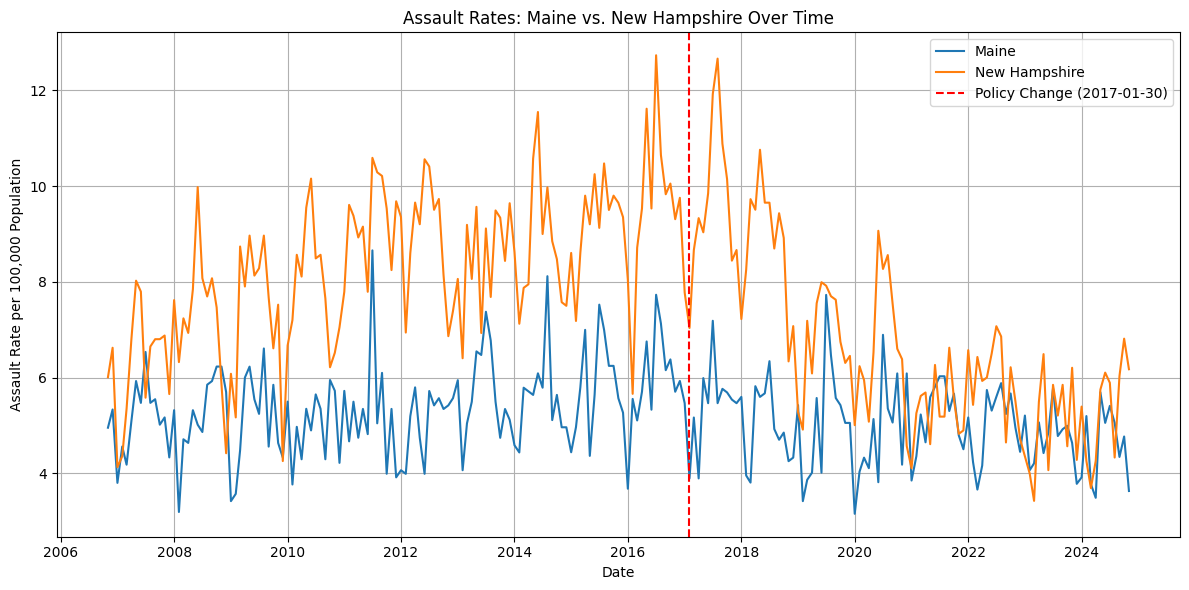

Time series plot for Maine vs. New Hampshire assault rates generated.


In [ ]:
policy_date_maine_nh = pd.to_datetime('2017-01-30')

# Filter assault_rates_df for Maine and New Hampshire
assault_maine_nh = assault_rates_df[assault_rates_df['State'].isin(['Maine', 'New Hampshire'])].copy()

# Plotting time series for Maine vs. New Hampshire
plt.figure(figsize=(12, 6))
for state in ['Maine', 'New Hampshire']:
    state_data = assault_maine_nh[assault_maine_nh['State'] == state]
    plt.plot(state_data['Date'], state_data['Assault_Rate'], label=state)

plt.axvline(x=policy_date_maine_nh, color='red', linestyle='--', label=f'Policy Change ({policy_date_maine_nh.strftime("%Y-%m-%d")})')
plt.title('Assault Rates: Maine vs. New Hampshire Over Time')
plt.xlabel('Date')
plt.ylabel('Assault Rate per 100,000 Population')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

print("Time series plot for Maine vs. New Hampshire assault rates generated.")

In [ ]:
policy_date_maine_nh = pd.to_datetime('2017-01-30')

# Prepare indicator variables for DID analysis
assault_maine_nh['Maine_Treated'] = assault_maine_nh['State'].apply(lambda x: 1 if x == 'Maine' else 0)
assault_maine_nh['Post_Legal'] = (assault_maine_nh['Date'] > policy_date_maine_nh).astype(int)

print("Indicator variables 'Maine_Treated' and 'Post_Legal' created.")
print(assault_maine_nh.head())

# Run OLS regression model
did_model_assault_maine_nh = smf.ols('Assault_Rate ~ Maine_Treated + Post_Legal + Maine_Treated:Post_Legal', data=assault_maine_nh).fit()
print("\nOLS Regression Model Summary for Assault Rates (Maine vs. New Hampshire):")
print(did_model_assault_maine_nh.summary())

Indicator variables 'Maine_Treated' and 'Post_Legal' created.
          Date  State  Assault  Population  Assault_Rate  Maine_Treated  \
434 2006-11-01  Maine       65   1312540.0      4.952230              1   
435 2006-12-01  Maine       70   1312540.0      5.333171              1   
436 2007-01-01  Maine       50   1315906.0      3.799664              1   
437 2007-02-01  Maine       60   1315906.0      4.559596              1   
438 2007-03-01  Maine       55   1315906.0      4.179630              1   

     Post_Legal  
434           0  
435           0  
436           0  
437           0  
438           0  

OLS Regression Model Summary for Assault Rates (Maine vs. New Hampshire):
                            OLS Regression Results                            
Dep. Variable:           Assault_Rate   R-squared:                       0.471
Model:                            OLS   Adj. R-squared:                  0.468
Method:                 Least Squares   F-statistic:               

##Virginia v. North Carolina


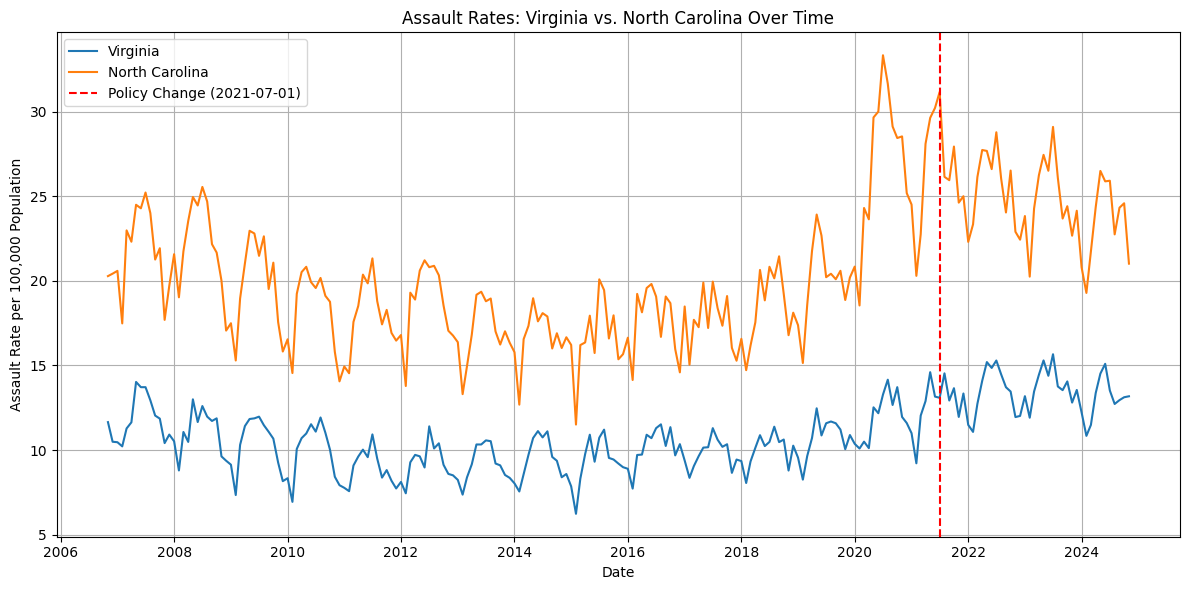

Time series plot for Virginia vs. North Carolina assault rates generated.


In [ ]:
policy_date_va_nc = pd.to_datetime('2021-07-01')

# Filter assault_rates_df for Virginia and North Carolina
assault_va_nc = assault_rates_df[assault_rates_df['State'].isin(['Virginia', 'North Carolina'])].copy()

# Plotting time series for Virginia vs. North Carolina
plt.figure(figsize=(12, 6))
for state in ['Virginia', 'North Carolina']:
    state_data = assault_va_nc[assault_va_nc['State'] == state]
    plt.plot(state_data['Date'], state_data['Assault_Rate'], label=state)

plt.axvline(x=policy_date_va_nc, color='red', linestyle='--', label=f'Policy Change ({policy_date_va_nc.strftime("%Y-%m-%d")})')
plt.title('Assault Rates: Virginia vs. North Carolina Over Time')
plt.xlabel('Date')
plt.ylabel('Assault Rate per 100,000 Population')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

print("Time series plot for Virginia vs. North Carolina assault rates generated.")

In [ ]:
policy_date_va_nc = pd.to_datetime('2021-07-01')

# Prepare indicator variables for DID analysis
assault_va_nc['Virginia_Treated'] = assault_va_nc['State'].apply(lambda x: 1 if x == 'Virginia' else 0)
assault_va_nc['Post_Legal'] = (assault_va_nc['Date'] > policy_date_va_nc).astype(int)

print("Indicator variables 'Virginia_Treated' and 'Post_Legal' created.")
print(assault_va_nc.head())

# Run OLS regression model
did_model_assault_va_nc = smf.ols('Assault_Rate ~ Virginia_Treated + Post_Legal + Virginia_Treated:Post_Legal', data=assault_va_nc).fit()
print("\nOLS Regression Model Summary for Assault Rates (Virginia vs. North Carolina):")
print(did_model_assault_va_nc.summary())

Indicator variables 'Virginia_Treated' and 'Post_Legal' created.
          Date           State  Assault  Population  Assault_Rate  \
868 2006-11-01  North Carolina     1808   8917270.0     20.275264   
869 2006-12-01  North Carolina     1821   8917270.0     20.421048   
870 2007-01-01  North Carolina     1877   9118037.0     20.585571   
871 2007-02-01  North Carolina     1594   9118037.0     17.481833   
872 2007-03-01  North Carolina     2095   9118037.0     22.976437   

     Virginia_Treated  Post_Legal  
868                 0           0  
869                 0           0  
870                 0           0  
871                 0           0  
872                 0           0  

OLS Regression Model Summary for Assault Rates (Virginia vs. North Carolina):
                            OLS Regression Results                            
Dep. Variable:           Assault_Rate   R-squared:                       0.774
Model:                            OLS   Adj. R-squared:            

## Washington v. Idaho

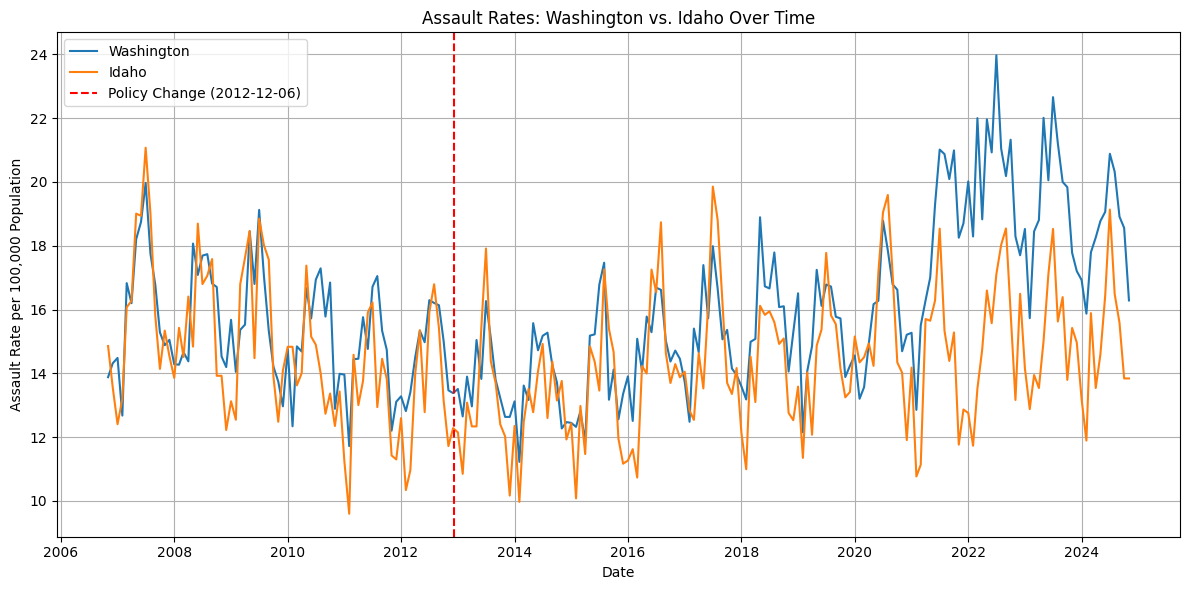

Time series plot for Washington vs. Idaho assault rates generated.


In [ ]:
policy_date_wa_id = pd.to_datetime('2012-12-06')

# Filter assault_rates_df for Washington and Idaho
assault_wa_id = assault_rates_df[assault_rates_df['State'].isin(['Washington', 'Idaho'])].copy()

# Plotting time series for Washington vs. Idaho
plt.figure(figsize=(12, 6))
for state in ['Washington', 'Idaho']:
    state_data = assault_wa_id[assault_wa_id['State'] == state]
    plt.plot(state_data['Date'], state_data['Assault_Rate'], label=state)

plt.axvline(x=policy_date_wa_id, color='red', linestyle='--', label=f'Policy Change ({policy_date_wa_id.strftime("%Y-%m-%d")})')
plt.title('Assault Rates: Washington vs. Idaho Over Time')
plt.xlabel('Date')
plt.ylabel('Assault Rate per 100,000 Population')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

print("Time series plot for Washington vs. Idaho assault rates generated.")

In [ ]:
policy_date_wa_id = pd.to_datetime('2012-12-06')

# Prepare indicator variables for DID analysis
assault_wa_id['Washington_Treated'] = assault_wa_id['State'].apply(lambda x: 1 if x == 'Washington' else 0)
assault_wa_id['Post_Legal'] = (assault_wa_id['Date'] > policy_date_wa_id).astype(int)

print("Indicator variables 'Washington_Treated' and 'Post_Legal' created.")
print(assault_wa_id.head())

# Run OLS regression model
did_model_assault_wa_id = smf.ols('Assault_Rate ~ Washington_Treated + Post_Legal + Washington_Treated:Post_Legal', data=assault_wa_id).fit()
print("\nOLS Regression Model Summary for Assault Rates (Washington vs. Idaho):")
print(did_model_assault_wa_id.summary())

Indicator variables 'Washington_Treated' and 'Post_Legal' created.
          Date  State  Assault  Population  Assault_Rate  Washington_Treated  \
217 2006-11-01  Idaho      218   1467474.0     14.855459                   0   
218 2006-12-01  Idaho      199   1467474.0     13.560717                   0   
219 2007-01-01  Idaho      186   1499501.0     12.404126                   0   
220 2007-02-01  Idaho      198   1499501.0     13.204393                   0   
221 2007-03-01  Idaho      241   1499501.0     16.072013                   0   

     Post_Legal  
217           0  
218           0  
219           0  
220           0  
221           0  

OLS Regression Model Summary for Assault Rates (Washington vs. Idaho):
                            OLS Regression Results                            
Dep. Variable:           Assault_Rate   R-squared:                       0.102
Model:                            OLS   Adj. R-squared:                  0.095
Method:                 Least Squar

# Analyze Homicide Rates

##Colorado v. Utah



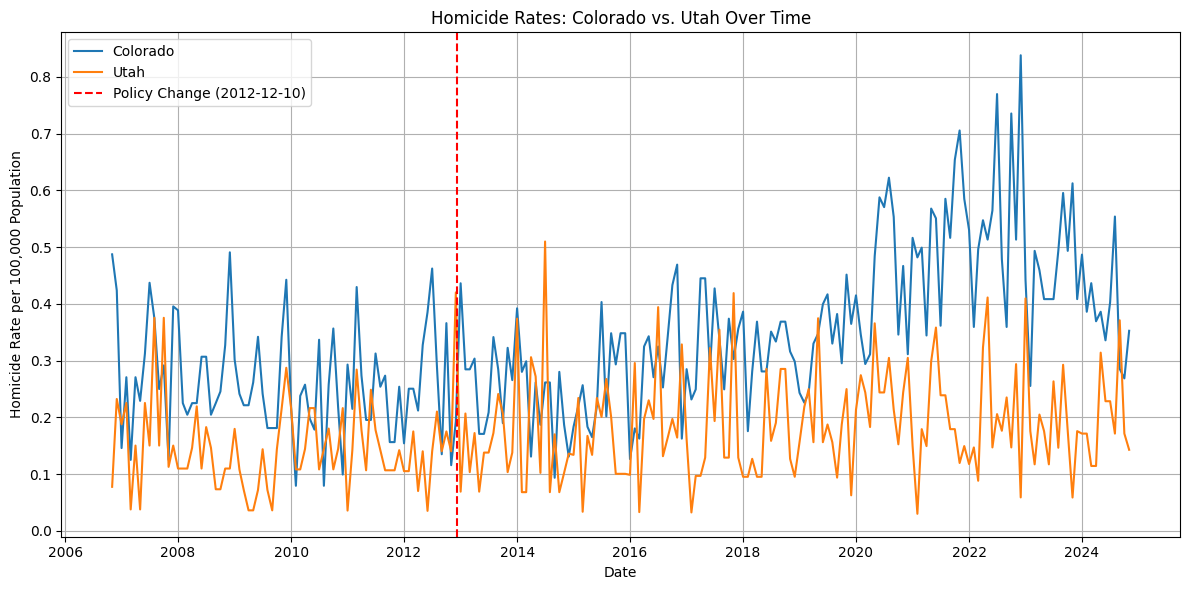

Time series plot for Colorado vs. Utah homicide rates generated.


In [ ]:
policy_date_co_ut = pd.to_datetime('2012-12-10')

# Filter homicide_rates_df for Colorado and Utah
homicide_co_ut = homicide_rates_df[homicide_rates_df['State'].isin(['Colorado', 'Utah'])].copy()

# Plotting time series for Colorado vs. Utah
plt.figure(figsize=(12, 6))
for state in ['Colorado', 'Utah']:
    state_data = homicide_co_ut[homicide_co_ut['State'] == state]
    plt.plot(state_data['Date'], state_data['Homicide_Rate'], label=state)

plt.axvline(x=policy_date_co_ut, color='red', linestyle='--', label=f'Policy Change ({policy_date_co_ut.strftime("%Y-%m-%d")})')
plt.title('Homicide Rates: Colorado vs. Utah Over Time')
plt.xlabel('Date')
plt.ylabel('Homicide Rate per 100,000 Population')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

print("Time series plot for Colorado vs. Utah homicide rates generated.")

In [ ]:
policy_date_co_ut = pd.to_datetime('2012-12-10')

# Prepare indicator variables for DID analysis
homicide_co_ut['Colorado_Treated'] = homicide_co_ut['State'].apply(lambda x: 1 if x == 'Colorado' else 0)
homicide_co_ut['Post_Legal'] = (homicide_co_ut['Date'] > policy_date_co_ut).astype(int)

print("Indicator variables 'Colorado_Treated' and 'Post_Legal' created.")
print(homicide_co_ut.head())

# Run OLS regression model
did_model_homicide_co_ut = smf.ols('Homicide_Rate ~ Colorado_Treated + Post_Legal + Colorado_Treated:Post_Legal', data=homicide_co_ut).fit()
print("\nOLS Regression Model Summary for Homicide Rates (Colorado vs. Utah):")
print(did_model_homicide_co_ut.summary())

Indicator variables 'Colorado_Treated' and 'Post_Legal' created.
        Date     State  Homicide  Population  Homicide_Rate  Colorado_Treated  \
0 2006-11-01  Colorado        23   4720423.0       0.487244                 1   
1 2006-12-01  Colorado        20   4720423.0       0.423691                 1   
2 2007-01-01  Colorado         7   4803868.0       0.145716                 1   
3 2007-02-01  Colorado        13   4803868.0       0.270615                 1   
4 2007-03-01  Colorado         6   4803868.0       0.124899                 1   

   Post_Legal  
0           0  
1           0  
2           0  
3           0  
4           0  

OLS Regression Model Summary for Homicide Rates (Colorado vs. Utah):
                            OLS Regression Results                            
Dep. Variable:          Homicide_Rate   R-squared:                       0.395
Model:                            OLS   Adj. R-squared:                  0.391
Method:                 Least Squares   F-sta

##Maine v. New Hampshire

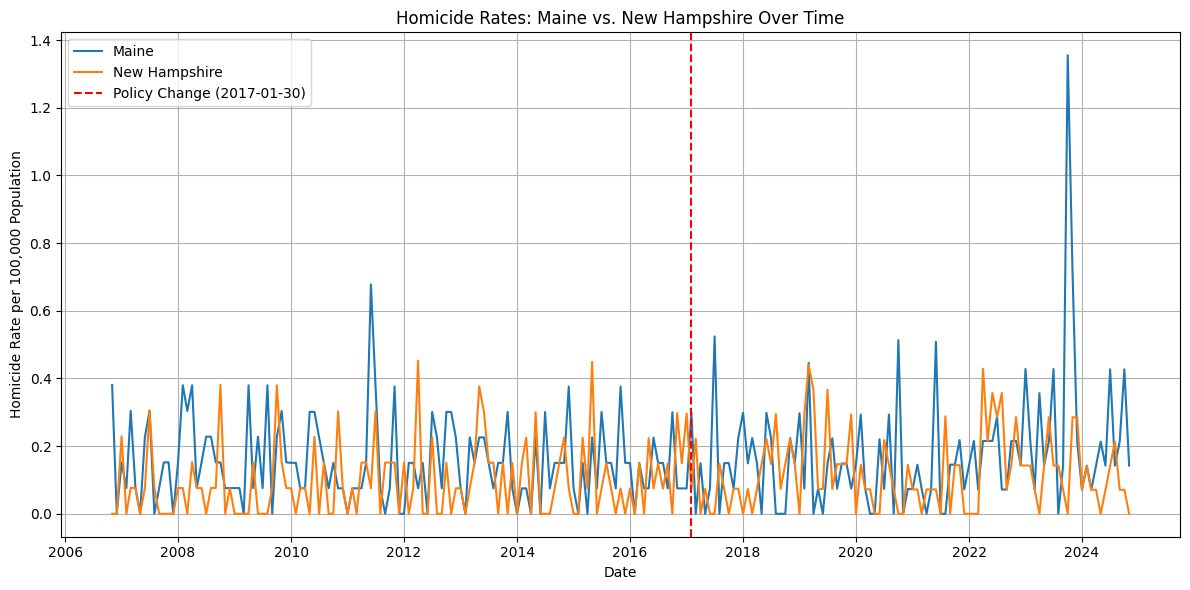

Time series plot for Maine vs. New Hampshire homicide rates generated.


In [ ]:
policy_date_maine_nh = pd.to_datetime('2017-01-30')

# Filter homicide_rates_df for Maine and New Hampshire
homicide_maine_nh = homicide_rates_df[homicide_rates_df['State'].isin(['Maine', 'New Hampshire'])].copy()

# Plotting time series for Maine vs. New Hampshire
plt.figure(figsize=(12, 6))
for state in ['Maine', 'New Hampshire']:
    state_data = homicide_maine_nh[homicide_maine_nh['State'] == state]
    plt.plot(state_data['Date'], state_data['Homicide_Rate'], label=state)

plt.axvline(x=policy_date_maine_nh, color='red', linestyle='--', label=f'Policy Change ({policy_date_maine_nh.strftime("%Y-%m-%d")})')
plt.title('Homicide Rates: Maine vs. New Hampshire Over Time')
plt.xlabel('Date')
plt.ylabel('Homicide Rate per 100,000 Population')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

print("Time series plot for Maine vs. New Hampshire homicide rates generated.")

In [ ]:
policy_date_maine_nh = pd.to_datetime('2017-01-30')

# Prepare indicator variables for DID analysis
homicide_maine_nh['Maine_Treated'] = homicide_maine_nh['State'].apply(lambda x: 1 if x == 'Maine' else 0)
homicide_maine_nh['Post_Legal'] = (homicide_maine_nh['Date'] > policy_date_maine_nh).astype(int)

print("Indicator variables 'Maine_Treated' and 'Post_Legal' created.")
print(homicide_maine_nh.head())

# Run OLS regression model
did_model_homicide_maine_nh = smf.ols('Homicide_Rate ~ Maine_Treated + Post_Legal + Maine_Treated:Post_Legal', data=homicide_maine_nh).fit()
print("\nOLS Regression Model Summary for Homicide Rates (Maine vs. New Hampshire):")
print(did_model_homicide_maine_nh.summary())

Indicator variables 'Maine_Treated' and 'Post_Legal' created.
          Date  State  Homicide  Population  Homicide_Rate  Maine_Treated  \
434 2006-11-01  Maine         5   1312540.0       0.380941              1   
435 2006-12-01  Maine         0   1312540.0       0.000000              1   
436 2007-01-01  Maine         2   1315906.0       0.151987              1   
437 2007-02-01  Maine         1   1315906.0       0.075993              1   
438 2007-03-01  Maine         4   1315906.0       0.303973              1   

     Post_Legal  
434           0  
435           0  
436           0  
437           0  
438           0  

OLS Regression Model Summary for Homicide Rates (Maine vs. New Hampshire):
                            OLS Regression Results                            
Dep. Variable:          Homicide_Rate   R-squared:                       0.053
Model:                            OLS   Adj. R-squared:                  0.046
Method:                 Least Squares   F-statistic:  

##Virginia v. North Carolina

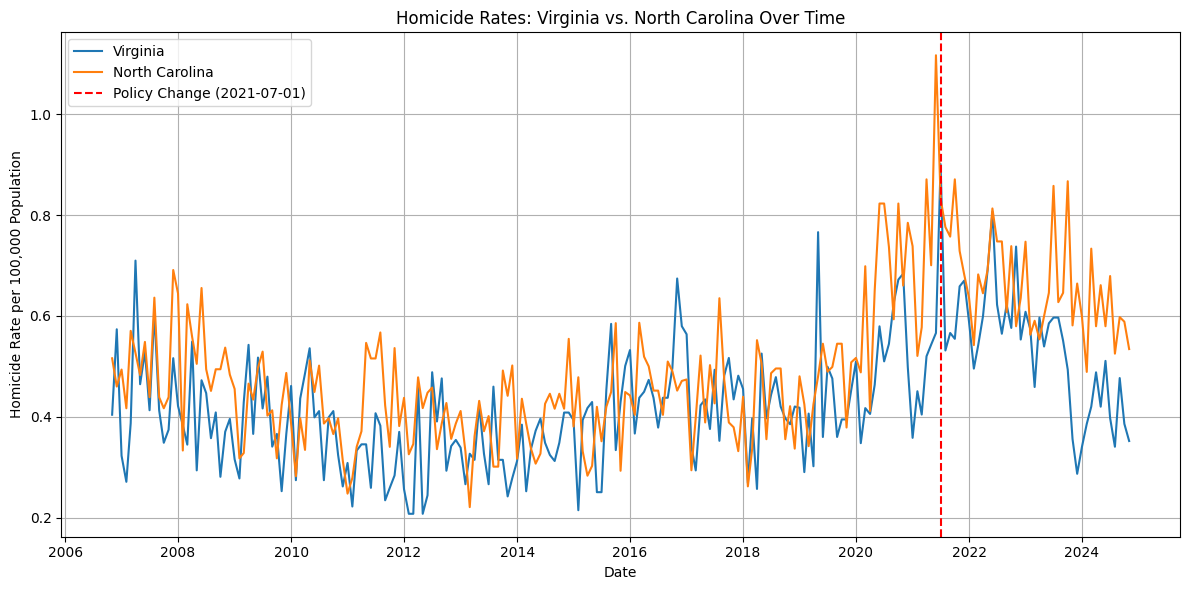

Time series plot for Virginia vs. North Carolina homicide rates generated.


In [ ]:
policy_date_va_nc = pd.to_datetime('2021-07-01')

# Filter homicide_rates_df for Virginia and North Carolina
homicide_va_nc = homicide_rates_df[homicide_rates_df['State'].isin(['Virginia', 'North Carolina'])].copy()

# Plotting time series for Virginia vs. North Carolina
plt.figure(figsize=(12, 6))
for state in ['Virginia', 'North Carolina']:
    state_data = homicide_va_nc[homicide_va_nc['State'] == state]
    plt.plot(state_data['Date'], state_data['Homicide_Rate'], label=state)

plt.axvline(x=policy_date_va_nc, color='red', linestyle='--', label=f'Policy Change ({policy_date_va_nc.strftime("%Y-%m-%d")})')
plt.title('Homicide Rates: Virginia vs. North Carolina Over Time')
plt.xlabel('Date')
plt.ylabel('Homicide Rate per 100,000 Population')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

print("Time series plot for Virginia vs. North Carolina homicide rates generated.")

In [ ]:
policy_date_va_nc = pd.to_datetime('2021-07-01')

# Prepare indicator variables for DID analysis
homicide_va_nc['Virginia_Treated'] = homicide_va_nc['State'].apply(lambda x: 1 if x == 'Virginia' else 0)
homicide_va_nc['Post_Legal'] = (homicide_va_nc['Date'] > policy_date_va_nc).astype(int)

print("Indicator variables 'Virginia_Treated' and 'Post_Legal' created.")
print(homicide_va_nc.head())

# Run OLS regression model
did_model_homicide_va_nc = smf.ols('Homicide_Rate ~ Virginia_Treated + Post_Legal + Virginia_Treated:Post_Legal', data=homicide_va_nc).fit()
print("\nOLS Regression Model Summary for Homicide Rates (Virginia vs. North Carolina):")
print(did_model_homicide_va_nc.summary())

Indicator variables 'Virginia_Treated' and 'Post_Legal' created.
          Date           State  Homicide  Population  Homicide_Rate  \
868 2006-11-01  North Carolina        46   8917270.0       0.515853   
869 2006-12-01  North Carolina        41   8917270.0       0.459782   
870 2007-01-01  North Carolina        45   9118037.0       0.493527   
871 2007-02-01  North Carolina        38   9118037.0       0.416756   
872 2007-03-01  North Carolina        52   9118037.0       0.570298   

     Virginia_Treated  Post_Legal  
868                 0           0  
869                 0           0  
870                 0           0  
871                 0           0  
872                 0           0  

OLS Regression Model Summary for Homicide Rates (Virginia vs. North Carolina):
                            OLS Regression Results                            
Dep. Variable:          Homicide_Rate   R-squared:                       0.277
Model:                            OLS   Adj. R-squared

##Washington v. Idaho



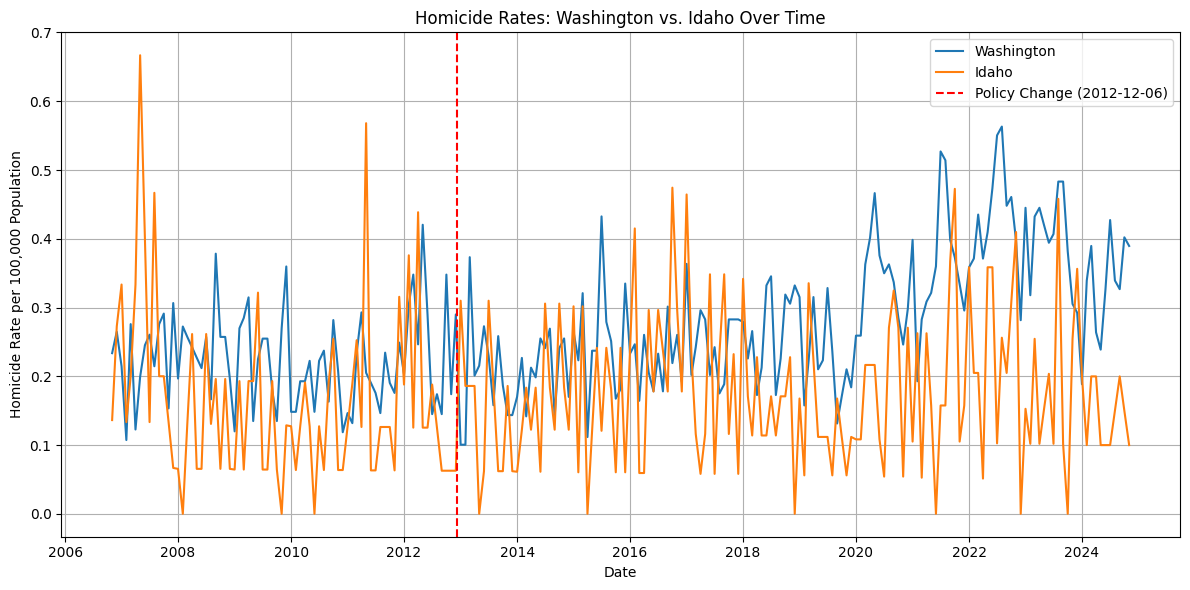

Time series plot for Washington vs. Idaho homicide rates generated.


In [ ]:
policy_date_wa_id = pd.to_datetime('2012-12-06')

# Filter homicide_rates_df for Washington and Idaho
homicide_wa_id = homicide_rates_df[homicide_rates_df['State'].isin(['Washington', 'Idaho'])].copy()

# Plotting time series for Washington vs. Idaho
plt.figure(figsize=(12, 6))
for state in ['Washington', 'Idaho']:
    state_data = homicide_wa_id[homicide_wa_id['State'] == state]
    plt.plot(state_data['Date'], state_data['Homicide_Rate'], label=state)

plt.axvline(x=policy_date_wa_id, color='red', linestyle='--', label=f'Policy Change ({policy_date_wa_id.strftime("%Y-%m-%d")})')
plt.title('Homicide Rates: Washington vs. Idaho Over Time')
plt.xlabel('Date')
plt.ylabel('Homicide Rate per 100,000 Population')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

print("Time series plot for Washington vs. Idaho homicide rates generated.")

In [ ]:
policy_date_wa_id = pd.to_datetime('2012-12-06')

# Prepare indicator variables for DID analysis
homicide_wa_id['Washington_Treated'] = homicide_wa_id['State'].apply(lambda x: 1 if x == 'Washington' else 0)
homicide_wa_id['Post_Legal'] = (homicide_wa_id['Date'] > policy_date_wa_id).astype(int)

print("Indicator variables 'Washington_Treated' and 'Post_Legal' created.")
print(homicide_wa_id.head())

# Run OLS regression model
did_model_homicide_wa_id = smf.ols('Homicide_Rate ~ Washington_Treated + Post_Legal + Washington_Treated:Post_Legal', data=homicide_wa_id).fit()
print("\nOLS Regression Model Summary for Homicide Rates (Washington vs. Idaho):")
print(did_model_homicide_wa_id.summary())

Indicator variables 'Washington_Treated' and 'Post_Legal' created.
          Date  State  Homicide  Population  Homicide_Rate  \
217 2006-11-01  Idaho         2   1467474.0       0.136289   
218 2006-12-01  Idaho         4   1467474.0       0.272577   
219 2007-01-01  Idaho         5   1499501.0       0.333444   
220 2007-02-01  Idaho         2   1499501.0       0.133378   
221 2007-03-01  Idaho         3   1499501.0       0.200067   

     Washington_Treated  Post_Legal  
217                   0           0  
218                   0           0  
219                   0           0  
220                   0           0  
221                   0           0  

OLS Regression Model Summary for Homicide Rates (Washington vs. Idaho):
                            OLS Regression Results                            
Dep. Variable:          Homicide_Rate   R-squared:                       0.202
Model:                            OLS   Adj. R-squared:                  0.196
Method:               

# Analyze Rape Rates


##Colorado v. Utah

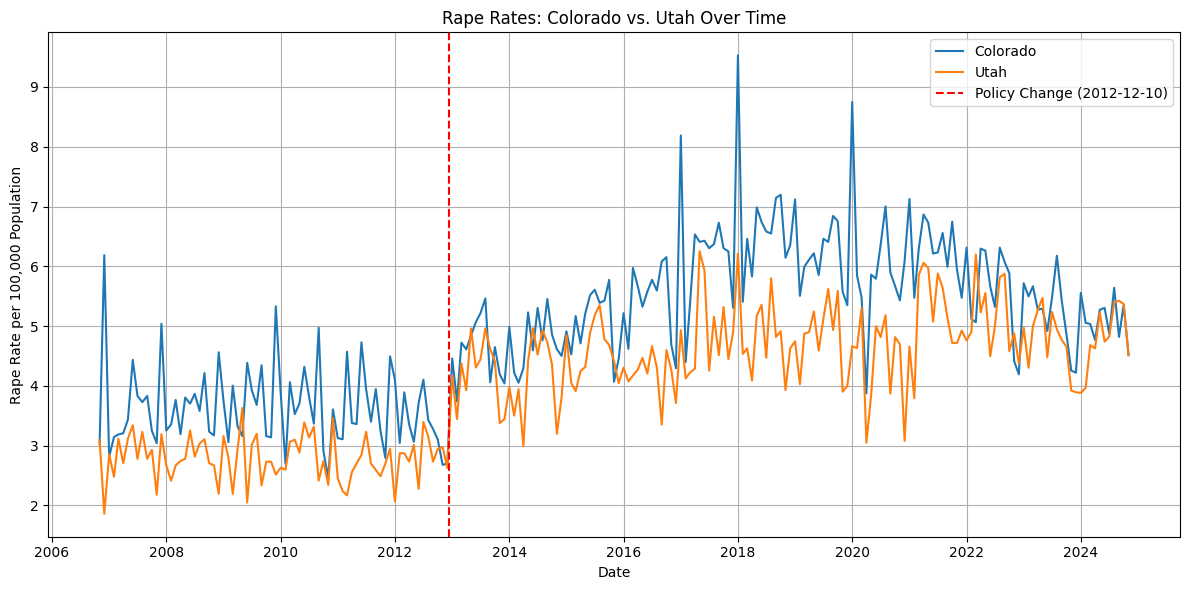

Time series plot for Colorado vs. Utah rape rates generated.


In [ ]:
policy_date_co_ut = pd.to_datetime('2012-12-10')

# Filter rape_rates_df for Colorado and Utah
rape_co_ut = rape_rates_df[rape_rates_df['State'].isin(['Colorado', 'Utah'])].copy()

# Plotting time series for Colorado vs. Utah
plt.figure(figsize=(12, 6))
for state in ['Colorado', 'Utah']:
    state_data = rape_co_ut[rape_co_ut['State'] == state]
    plt.plot(state_data['Date'], state_data['Rape_Rate'], label=state)

plt.axvline(x=policy_date_co_ut, color='red', linestyle='--', label=f'Policy Change ({policy_date_co_ut.strftime("%Y-%m-%d")})')
plt.title('Rape Rates: Colorado vs. Utah Over Time')
plt.xlabel('Date')
plt.ylabel('Rape Rate per 100,000 Population')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

print("Time series plot for Colorado vs. Utah rape rates generated.")

In [ ]:
policy_date_co_ut = pd.to_datetime('2012-12-10')

# Prepare indicator variables for DID analysis
rape_co_ut['Colorado_Treated'] = rape_co_ut['State'].apply(lambda x: 1 if x == 'Colorado' else 0)
rape_co_ut['Post_Legal'] = (rape_co_ut['Date'] > policy_date_co_ut).astype(int)

print("Indicator variables 'Colorado_Treated' and 'Post_Legal' created.")
print(rape_co_ut.head())

# Run OLS regression model
did_model_rape_co_ut = smf.ols('Rape_Rate ~ Colorado_Treated + Post_Legal + Colorado_Treated:Post_Legal', data=rape_co_ut).fit()
print("\nOLS Regression Model Summary for Rape Rates (Colorado vs. Utah):")
print(did_model_rape_co_ut.summary())

Indicator variables 'Colorado_Treated' and 'Post_Legal' created.
        Date     State  Rape  Population  Rape_Rate  Colorado_Treated  \
0 2006-11-01  Colorado   143   4720423.0   3.029390                 1   
1 2006-12-01  Colorado   292   4720423.0   6.185886                 1   
2 2007-01-01  Colorado   135   4803868.0   2.810235                 1   
3 2007-02-01  Colorado   151   4803868.0   3.143300                 1   
4 2007-03-01  Colorado   153   4803868.0   3.184933                 1   

   Post_Legal  
0           0  
1           0  
2           0  
3           0  
4           0  

OLS Regression Model Summary for Rape Rates (Colorado vs. Utah):
                            OLS Regression Results                            
Dep. Variable:              Rape_Rate   R-squared:                       0.658
Model:                            OLS   Adj. R-squared:                  0.656
Method:                 Least Squares   F-statistic:                     275.9
Date:             

## Maine v. New Hampshire

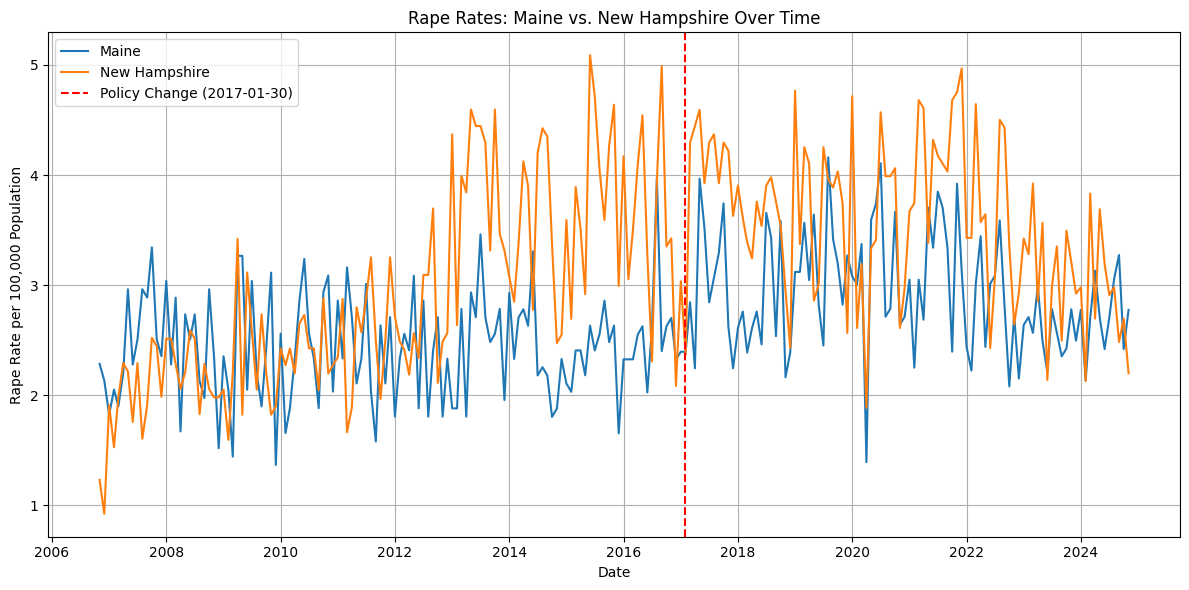

Time series plot for Maine vs. New Hampshire rape rates generated.


In [ ]:
policy_date_maine_nh = pd.to_datetime('2017-01-30')

# Filter rape_rates_df for Maine and New Hampshire
rape_maine_nh = rape_rates_df[rape_rates_df['State'].isin(['Maine', 'New Hampshire'])].copy()

# Plotting time series for Maine vs. New Hampshire
plt.figure(figsize=(12, 6))
for state in ['Maine', 'New Hampshire']:
    state_data = rape_maine_nh[rape_maine_nh['State'] == state]
    plt.plot(state_data['Date'], state_data['Rape_Rate'], label=state)

plt.axvline(x=policy_date_maine_nh, color='red', linestyle='--', label=f'Policy Change ({policy_date_maine_nh.strftime("%Y-%m-%d")})')
plt.title('Rape Rates: Maine vs. New Hampshire Over Time')
plt.xlabel('Date')
plt.ylabel('Rape Rate per 100,000 Population')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

print("Time series plot for Maine vs. New Hampshire rape rates generated.")

In [ ]:
policy_date_maine_nh = pd.to_datetime('2017-01-30')

# Prepare indicator variables for DID analysis
rape_maine_nh['Maine_Treated'] = rape_maine_nh['State'].apply(lambda x: 1 if x == 'Maine' else 0)
rape_maine_nh['Post_Legal'] = (rape_maine_nh['Date'] > policy_date_maine_nh).astype(int)

print("Indicator variables 'Maine_Treated' and 'Post_Legal' created.")
print(rape_maine_nh.head())

# Run OLS regression model
did_model_rape_maine_nh = smf.ols('Rape_Rate ~ Maine_Treated + Post_Legal + Maine_Treated:Post_Legal', data=rape_maine_nh).fit()
print("\nOLS Regression Model Summary for Rape Rates (Maine vs. New Hampshire):")
print(did_model_rape_maine_nh.summary())

Indicator variables 'Maine_Treated' and 'Post_Legal' created.
          Date  State  Rape  Population  Rape_Rate  Maine_Treated  Post_Legal
434 2006-11-01  Maine    30   1312540.0   2.285645              1           0
435 2006-12-01  Maine    28   1312540.0   2.133268              1           0
436 2007-01-01  Maine    24   1315906.0   1.823838              1           0
437 2007-02-01  Maine    27   1315906.0   2.051818              1           0
438 2007-03-01  Maine    25   1315906.0   1.899832              1           0

OLS Regression Model Summary for Rape Rates (Maine vs. New Hampshire):
                            OLS Regression Results                            
Dep. Variable:              Rape_Rate   R-squared:                       0.255
Model:                            OLS   Adj. R-squared:                  0.250
Method:                 Least Squares   F-statistic:                     49.14
Date:                Tue, 09 Dec 2025   Prob (F-statistic):           2.51e-27
Tim

## Virginia v. North Carolina

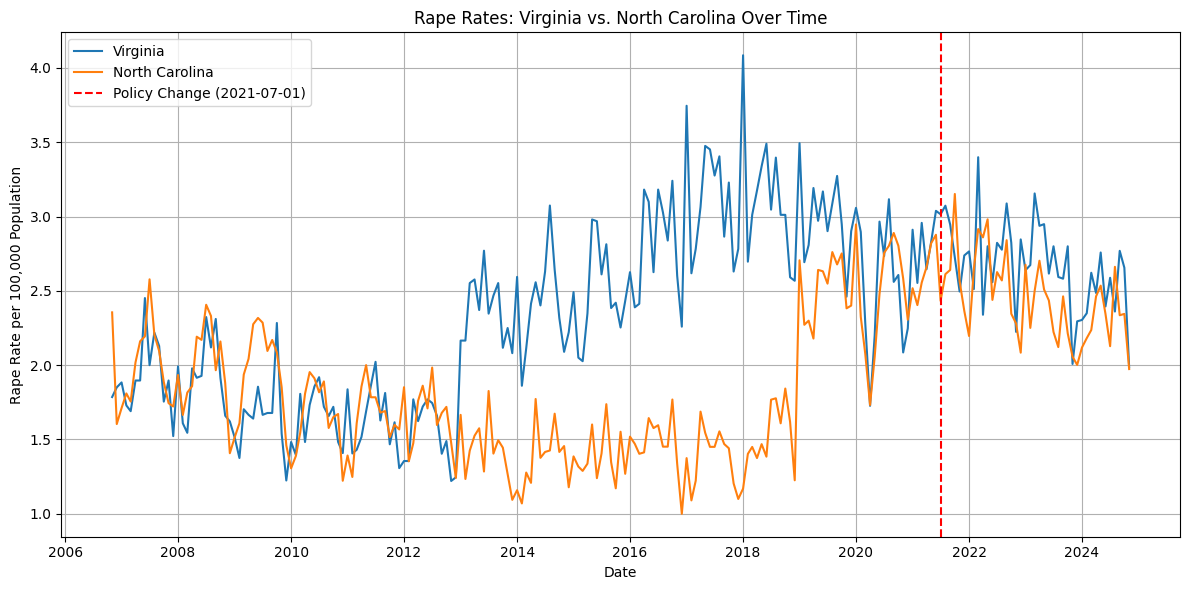

Time series plot for Virginia vs. North Carolina rape rates generated.


In [ ]:
policy_date_va_nc = pd.to_datetime('2021-07-01')

# Filter rape_rates_df for Virginia and North Carolina
rape_va_nc = rape_rates_df[rape_rates_df['State'].isin(['Virginia', 'North Carolina'])].copy()

# Plotting time series for Virginia vs. North Carolina
plt.figure(figsize=(12, 6))
for state in ['Virginia', 'North Carolina']:
    state_data = rape_va_nc[rape_va_nc['State'] == state]
    plt.plot(state_data['Date'], state_data['Rape_Rate'], label=state)

plt.axvline(x=policy_date_va_nc, color='red', linestyle='--', label=f'Policy Change ({policy_date_va_nc.strftime("%Y-%m-%d")})')
plt.title('Rape Rates: Virginia vs. North Carolina Over Time')
plt.xlabel('Date')
plt.ylabel('Rape Rate per 100,000 Population')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

print("Time series plot for Virginia vs. North Carolina rape rates generated.")

In [ ]:
policy_date_va_nc = pd.to_datetime('2021-07-01')

# Prepare indicator variables for DID analysis
rape_va_nc['Virginia_Treated'] = rape_va_nc['State'].apply(lambda x: 1 if x == 'Virginia' else 0)
rape_va_nc['Post_Legal'] = (rape_va_nc['Date'] > policy_date_va_nc).astype(int)

print("Indicator variables 'Virginia_Treated' and 'Post_Legal' created.")
print(rape_va_nc.head())

# Run OLS regression model
did_model_rape_va_nc = smf.ols('Rape_Rate ~ Virginia_Treated + Post_Legal + Virginia_Treated:Post_Legal', data=rape_va_nc).fit()
print("\nOLS Regression Model Summary for Rape Rates (Virginia vs. North Carolina):")
print(did_model_rape_va_nc.summary())

Indicator variables 'Virginia_Treated' and 'Post_Legal' created.
          Date           State  Rape  Population  Rape_Rate  Virginia_Treated  \
868 2006-11-01  North Carolina   210   8917270.0   2.354981                 0   
869 2006-12-01  North Carolina   143   8917270.0   1.603630                 0   
870 2007-01-01  North Carolina   156   9118037.0   1.710895                 0   
871 2007-02-01  North Carolina   165   9118037.0   1.809600                 0   
872 2007-03-01  North Carolina   160   9118037.0   1.754764                 0   

     Post_Legal  
868           0  
869           0  
870           0  
871           0  
872           0  

OLS Regression Model Summary for Rape Rates (Virginia vs. North Carolina):
                            OLS Regression Results                            
Dep. Variable:              Rape_Rate   R-squared:                       0.270
Model:                            OLS   Adj. R-squared:                  0.265
Method:                 Lea

## Washington v. Idaho

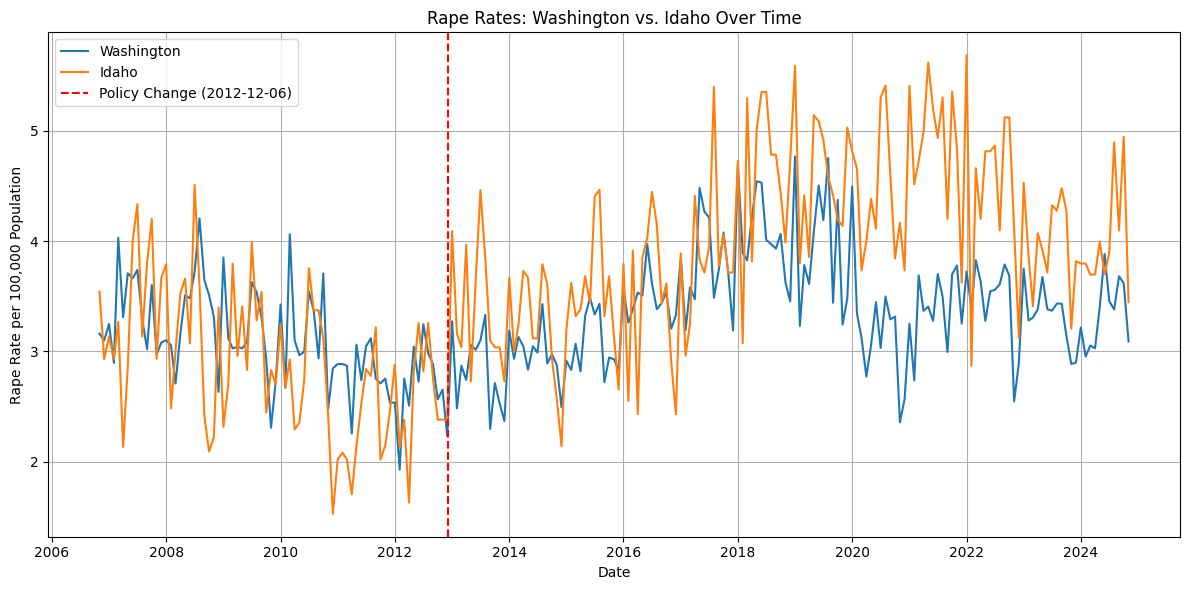

Time series plot for Washington vs. Idaho rape rates generated.


In [ ]:
policy_date_wa_id = pd.to_datetime('2012-12-06')

# Filter rape_rates_df for Washington and Idaho
rape_wa_id = rape_rates_df[rape_rates_df['State'].isin(['Washington', 'Idaho'])].copy()

# Plotting time series for Washington vs. Idaho
plt.figure(figsize=(12, 6))
for state in ['Washington', 'Idaho']:
    state_data = rape_wa_id[rape_wa_id['State'] == state]
    plt.plot(state_data['Date'], state_data['Rape_Rate'], label=state)

plt.axvline(x=policy_date_wa_id, color='red', linestyle='--', label=f'Policy Change ({policy_date_wa_id.strftime("%Y-%m-%d")})')
plt.title('Rape Rates: Washington vs. Idaho Over Time')
plt.xlabel('Date')
plt.ylabel('Rape Rate per 100,000 Population')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

print("Time series plot for Washington vs. Idaho rape rates generated.")

In [ ]:
policy_date_wa_id = pd.to_datetime('2012-12-06')

# Prepare indicator variables for DID analysis
rape_wa_id['Washington_Treated'] = rape_wa_id['State'].apply(lambda x: 1 if x == 'Washington' else 0)
rape_wa_id['Post_Legal'] = (rape_wa_id['Date'] > policy_date_wa_id).astype(int)

print("Indicator variables 'Washington_Treated' and 'Post_Legal' created.")
print(rape_wa_id.head())

# Run OLS regression model
did_model_rape_wa_id = smf.ols('Rape_Rate ~ Washington_Treated + Post_Legal + Washington_Treated:Post_Legal', data=rape_wa_id).fit()
print("\nOLS Regression Model Summary for Rape Rates (Washington vs. Idaho):")
print(did_model_rape_wa_id.summary())

Indicator variables 'Washington_Treated' and 'Post_Legal' created.
          Date  State  Rape  Population  Rape_Rate  Washington_Treated  \
217 2006-11-01  Idaho    52   1467474.0   3.543504                   0   
218 2006-12-01  Idaho    43   1467474.0   2.930205                   0   
219 2007-01-01  Idaho    47   1499501.0   3.134376                   0   
220 2007-02-01  Idaho    44   1499501.0   2.934309                   0   
221 2007-03-01  Idaho    49   1499501.0   3.267754                   0   

     Post_Legal  
217           0  
218           0  
219           0  
220           0  
221           0  

OLS Regression Model Summary for Rape Rates (Washington vs. Idaho):
                            OLS Regression Results                            
Dep. Variable:              Rape_Rate   R-squared:                       0.326
Model:                            OLS   Adj. R-squared:                  0.321
Method:                 Least Squares   F-statistic:                     6

# Analyze Robbery Rates

##Colorado v. Utah



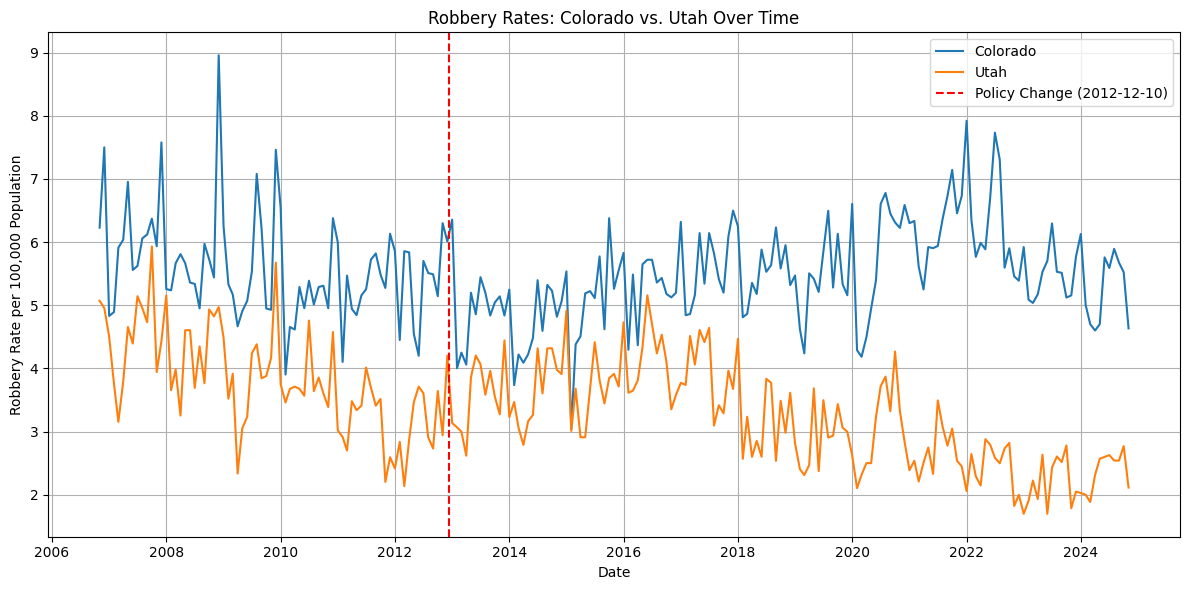

Time series plot for Colorado vs. Utah robbery rates generated.


In [ ]:
policy_date_co_ut = pd.to_datetime('2012-12-10')

# Filter robbery_rates_df for Colorado and Utah
robbery_co_ut = robbery_rates_df[robbery_rates_df['State'].isin(['Colorado', 'Utah'])].copy()

# Plotting time series for Colorado vs. Utah
plt.figure(figsize=(12, 6))
for state in ['Colorado', 'Utah']:
    state_data = robbery_co_ut[robbery_co_ut['State'] == state]
    plt.plot(state_data['Date'], state_data['Robbery_Rate'], label=state)

plt.axvline(x=policy_date_co_ut, color='red', linestyle='--', label=f'Policy Change ({policy_date_co_ut.strftime("%Y-%m-%d")})')
plt.title('Robbery Rates: Colorado vs. Utah Over Time')
plt.xlabel('Date')
plt.ylabel('Robbery Rate per 100,000 Population')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

print("Time series plot for Colorado vs. Utah robbery rates generated.")

In [ ]:
policy_date_co_ut = pd.to_datetime('2012-12-10')

# Prepare indicator variables for DID analysis
robbery_co_ut['Colorado_Treated'] = robbery_co_ut['State'].apply(lambda x: 1 if x == 'Colorado' else 0)
robbery_co_ut['Post_Legal'] = (robbery_co_ut['Date'] > policy_date_co_ut).astype(int)

print("Indicator variables 'Colorado_Treated' and 'Post_Legal' created.")
print(robbery_co_ut.head())

# Run OLS regression model
did_model_robbery_co_ut = smf.ols('Robbery_Rate ~ Colorado_Treated + Post_Legal + Colorado_Treated:Post_Legal', data=robbery_co_ut).fit()
print("\nOLS Regression Model Summary for Robbery Rates (Colorado vs. Utah):")
print(did_model_robbery_co_ut.summary())

Indicator variables 'Colorado_Treated' and 'Post_Legal' created.
        Date     State  Robbery  Population  Robbery_Rate  Colorado_Treated  \
0 2006-11-01  Colorado      294   4720423.0      6.228255                 1   
1 2006-12-01  Colorado      354   4720423.0      7.499328                 1   
2 2007-01-01  Colorado      232   4803868.0      4.829442                 1   
3 2007-02-01  Colorado      235   4803868.0      4.891891                 1   
4 2007-03-01  Colorado      284   4803868.0      5.911903                 1   

   Post_Legal  
0           0  
1           0  
2           0  
3           0  
4           0  

OLS Regression Model Summary for Robbery Rates (Colorado vs. Utah):
                            OLS Regression Results                            
Dep. Variable:           Robbery_Rate   R-squared:                       0.651
Model:                            OLS   Adj. R-squared:                  0.648
Method:                 Least Squares   F-statistic:      

## Maine v. New Hampshire

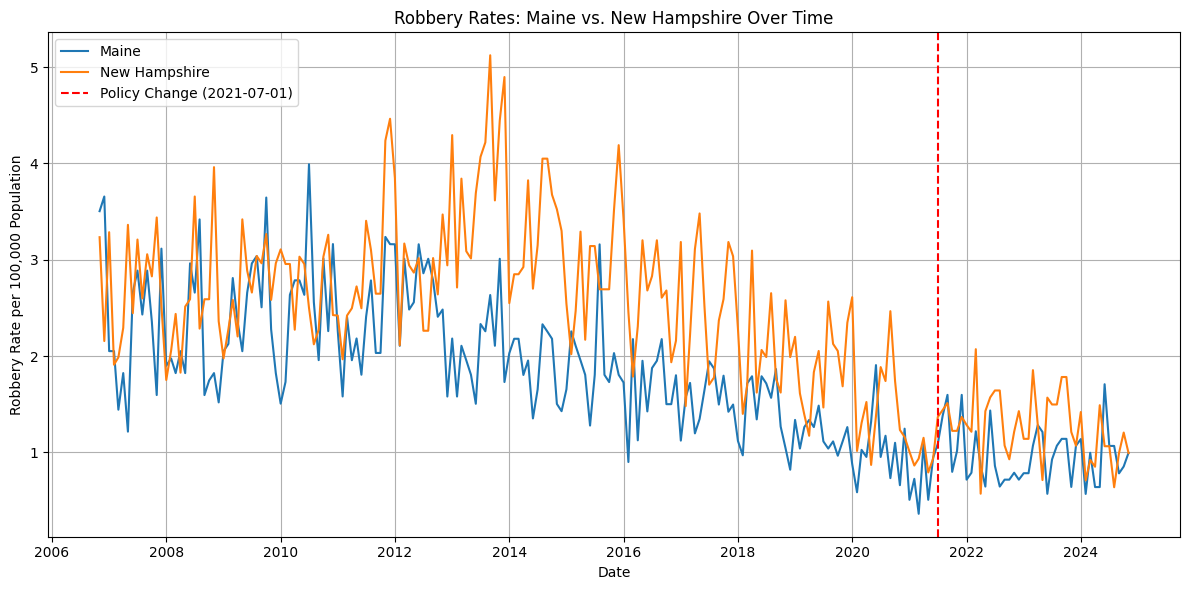

Time series plot for Maine vs. New Hampshire robbery rates generated.


In [ ]:
policy_date_maine_nh = pd.to_datetime('2017-01-30')

# Filter robbery_rates_df for Maine and New Hampshire
robbery_maine_nh = robbery_rates_df[robbery_rates_df['State'].isin(['Maine', 'New Hampshire'])].copy()

plt.figure(figsize=(12, 6))
for state in ['Maine', 'New Hampshire']:
    state_data = robbery_maine_nh[robbery_maine_nh['State'] == state]
    plt.plot(state_data['Date'], state_data['Robbery_Rate'], label=state)

plt.axvline(x=policy_date_va_nc, color='red', linestyle='--', label=f'Policy Change ({policy_date_va_nc.strftime("%Y-%m-%d")})')
plt.title('Robbery Rates: Maine vs. New Hampshire Over Time')
plt.xlabel('Date')
plt.ylabel('Robbery Rate per 100,000 Population')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

print("Time series plot for Maine vs. New Hampshire robbery rates generated.")

In [ ]:
# Prepare indicator variables for DID analysis
robbery_maine_nh['Maine_Treated'] = robbery_maine_nh['State'].apply(lambda x: 1 if x == 'Maine' else 0)
robbery_maine_nh['Post_Legal'] = (robbery_maine_nh['Date'] > policy_date_maine_nh).astype(int)

print("Indicator variables 'Maine_Treated' and 'Post_Legal' created.")
print(robbery_maine_nh.head())

# Run OLS regression model
did_model_robbery_maine_nh = smf.ols('Robbery_Rate ~ Maine_Treated + Post_Legal + Maine_Treated:Post_Legal', data=robbery_maine_nh).fit()
print("\nOLS Regression Model Summary for Robbery Rates (Maine vs. New Hampshire):")
print(did_model_robbery_maine_nh.summary())

Indicator variables 'Maine_Treated' and 'Post_Legal' created.
          Date  State  Robbery  Population  Robbery_Rate  Maine_Treated  \
434 2006-11-01  Maine       46   1312540.0      3.504655              1   
435 2006-12-01  Maine       48   1312540.0      3.657031              1   
436 2007-01-01  Maine       27   1315906.0      2.051818              1   
437 2007-02-01  Maine       27   1315906.0      2.051818              1   
438 2007-03-01  Maine       19   1315906.0      1.443872              1   

     Post_Legal  
434           0  
435           0  
436           0  
437           0  
438           0  

OLS Regression Model Summary for Robbery Rates (Maine vs. New Hampshire):
                            OLS Regression Results                            
Dep. Variable:           Robbery_Rate   R-squared:                       0.569
Model:                            OLS   Adj. R-squared:                  0.566
Method:                 Least Squares   F-statistic:               

##Virginia v. North Carolina

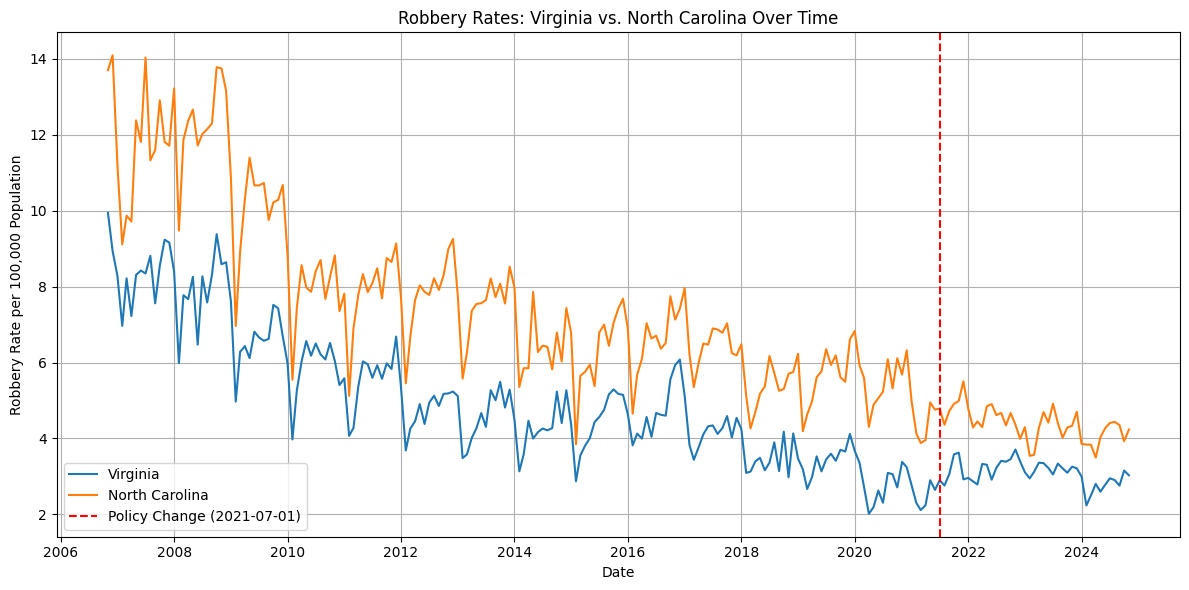

Time series plot for Virginia vs. North Carolina robbery rates generated.


In [ ]:
policy_date_va_nc = pd.to_datetime('2021-07-01')

# Filter robbery_rates_df for Virginia and North Carolina
robbery_va_nc = robbery_rates_df[robbery_rates_df['State'].isin(['Virginia', 'North Carolina'])].copy()

# Plotting time series for Virginia vs. North Carolina
plt.figure(figsize=(12, 6))
for state in ['Virginia', 'North Carolina']:
    state_data = robbery_va_nc[robbery_va_nc['State'] == state]
    plt.plot(state_data['Date'], state_data['Robbery_Rate'], label=state)

plt.axvline(x=policy_date_va_nc, color='red', linestyle='--', label=f'Policy Change ({policy_date_va_nc.strftime("%Y-%m-%d")})')
plt.title('Robbery Rates: Virginia vs. North Carolina Over Time')
plt.xlabel('Date')
plt.ylabel('Robbery Rate per 100,000 Population')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

print("Time series plot for Virginia vs. North Carolina robbery rates generated.")

In [ ]:
policy_date_va_nc = pd.to_datetime('2021-07-01')

# Prepare indicator variables for DID analysis
robbery_va_nc['Virginia_Treated'] = robbery_va_nc['State'].apply(lambda x: 1 if x == 'Virginia' else 0)
robbery_va_nc['Post_Legal'] = (robbery_va_nc['Date'] > policy_date_va_nc).astype(int)

print("Indicator variables 'Virginia_Treated' and 'Post_Legal' created.")
print(robbery_va_nc.head())

# Run OLS regression model
did_model_robbery_va_nc = smf.ols('Robbery_Rate ~ Virginia_Treated + Post_Legal + Virginia_Treated:Post_Legal', data=robbery_va_nc).fit()
print("\nOLS Regression Model Summary for Robbery Rates (Virginia vs. North Carolina):")
print(did_model_robbery_va_nc.summary())

Indicator variables 'Virginia_Treated' and 'Post_Legal' created.
          Date           State  Robbery  Population  Robbery_Rate  \
868 2006-11-01  North Carolina     1222   8917270.0     13.703746   
869 2006-12-01  North Carolina     1257   8917270.0     14.096242   
870 2007-01-01  North Carolina     1022   9118037.0     11.208553   
871 2007-02-01  North Carolina      831   9118037.0      9.113804   
872 2007-03-01  North Carolina      900   9118037.0      9.870546   

     Virginia_Treated  Post_Legal  
868                 0           0  
869                 0           0  
870                 0           0  
871                 0           0  
872                 0           0  

OLS Regression Model Summary for Robbery Rates (Virginia vs. North Carolina):
                            OLS Regression Results                            
Dep. Variable:           Robbery_Rate   R-squared:                       0.402
Model:                            OLS   Adj. R-squared:            

##Washington v. Idaho



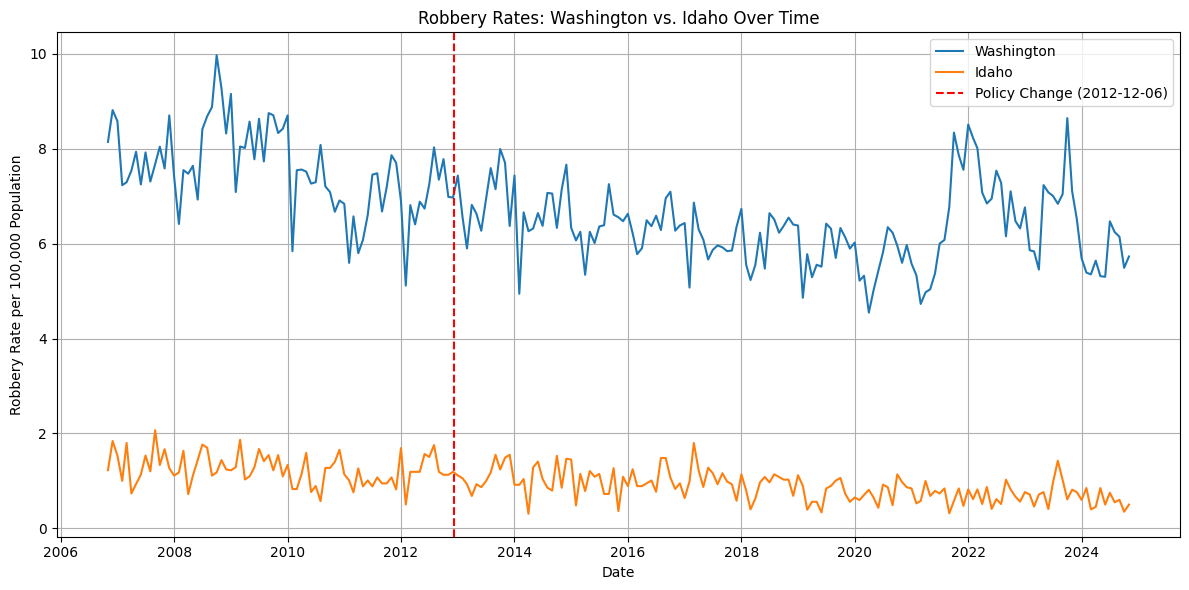

Time series plot for Washington vs. Idaho robbery rates generated.


In [ ]:
policy_date_wa_id = pd.to_datetime('2012-12-06')

# Filter robbery_rates_df for Washington and Idaho
robbery_wa_id = robbery_rates_df[robbery_rates_df['State'].isin(['Washington', 'Idaho'])].copy()

# Plotting time series for Washington vs. Idaho
plt.figure(figsize=(12, 6))
for state in ['Washington', 'Idaho']:
    state_data = robbery_wa_id[robbery_wa_id['State'] == state]
    plt.plot(state_data['Date'], state_data['Robbery_Rate'], label=state)

plt.axvline(x=policy_date_wa_id, color='red', linestyle='--', label=f'Policy Change ({policy_date_wa_id.strftime("%Y-%m-%d")})')
plt.title('Robbery Rates: Washington vs. Idaho Over Time')
plt.xlabel('Date')
plt.ylabel('Robbery Rate per 100,000 Population')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

print("Time series plot for Washington vs. Idaho robbery rates generated.")

In [ ]:
policy_date_wa_id = pd.to_datetime('2012-12-06')

# Prepare indicator variables for DID analysis
robbery_wa_id['Washington_Treated'] = robbery_wa_id['State'].apply(lambda x: 1 if x == 'Washington' else 0)
robbery_wa_id['Post_Legal'] = (robbery_wa_id['Date'] > policy_date_wa_id).astype(int)

print("Indicator variables 'Washington_Treated' and 'Post_Legal' created.")
print(robbery_wa_id.head())

# Run OLS regression model
did_model_robbery_wa_id = smf.ols('Robbery_Rate ~ Washington_Treated + Post_Legal + Washington_Treated:Post_Legal', data=robbery_wa_id).fit()
print("\nOLS Regression Model Summary for Robbery Rates (Washington vs. Idaho):")
print(did_model_robbery_wa_id.summary())

Indicator variables 'Washington_Treated' and 'Post_Legal' created.
          Date  State  Robbery  Population  Robbery_Rate  Washington_Treated  \
217 2006-11-01  Idaho       18   1467474.0      1.226598                   0   
218 2006-12-01  Idaho       27   1467474.0      1.839896                   0   
219 2007-01-01  Idaho       23   1499501.0      1.533844                   0   
220 2007-02-01  Idaho       15   1499501.0      1.000333                   0   
221 2007-03-01  Idaho       27   1499501.0      1.800599                   0   

     Post_Legal  
217           0  
218           0  
219           0  
220           0  
221           0  

OLS Regression Model Summary for Robbery Rates (Washington vs. Idaho):
                            OLS Regression Results                            
Dep. Variable:           Robbery_Rate   R-squared:                       0.956
Model:                            OLS   Adj. R-squared:                  0.956
Method:                 Least Squar